<a href="https://colab.research.google.com/github/leifolson/tf-cert-practice/blob/main/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Check GPU since we plan to used mixed precision.  Need a Tesla T4 or better.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ef3397fa-cb82-f171-0876-57eb8785e988)


In [3]:
# grab a few helper functions
!wget "https://raw.githubusercontent.com/leifolson/tf-cert-practice/main/helper_functions.py"

--2024-01-30 00:45:47--  https://raw.githubusercontent.com/leifolson/tf-cert-practice/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-30 00:45:47 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using Food-101 from TF Datasets

In [5]:
import tensorflow_datasets as tfds

In [6]:
[d for d in tfds.list_builders() if 'food' in d]

['food101', 'huggingface:food101', 'robotics:cmu_playing_with_food']

In [ ]:
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
ds_info

In [ ]:
example = list(train_data.take(1))[0]

In [ ]:
image, label = example

In [ ]:
plt.imshow(image)
plt.title('{} Image'.format(ds_info.features['label'].names[label]));

## Preprocessing

In [ ]:
def preprocess(image, label, img_shape=(224, 224)):
  """
  Reshape and change datatype to float32
  """
  image = tf.image.resize(image, img_shape)
  image = tf.cast(image, tf.float32)
  return image, label

In [ ]:
image.dtype, image.shape

(tf.uint8, TensorShape([512, 512, 3]))

In [ ]:
image2, label2 = preprocess(image, label)

In [ ]:
image2.dtype, image2.shape, label2

(tf.float32,
 TensorShape([224, 224, 3]),
 <tf.Tensor: shape=(), dtype=int64, numpy=81>)

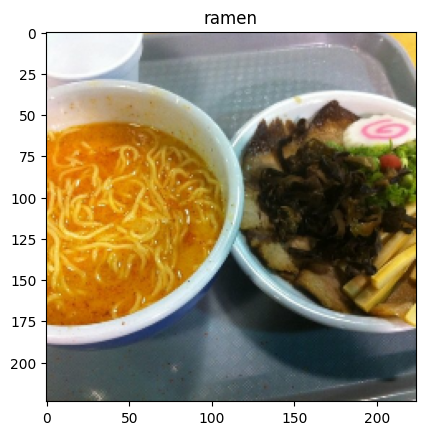

In [ ]:
plt.imshow(image2.numpy() / 255.)
plt.title(ds_info.features['label'].names[label2]);

In [ ]:
# prepare train and test data
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10_000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Setting up checkpoints


In [ ]:
ckpt_path = 'model_checkpoints/cp.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_acc',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

## Set up mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision

In [ ]:
mixed_precision.set_global_policy('mixed_float16')